In [3]:
import os, datetime
import pandas as pd
import numpy as np
from prophet import Prophet

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Set the maximum number of row to be displayed
pd.options.display.max_rows = 100

In [5]:
col1 = ["Average_Price", "Average_Price_SA"]
col2 = ["Monthly_Change", "Annual_Change"]
NEW_PATH = os.path.join(Path.cwd().parents[1],"data","uk_house_price")

print(NEW_PATH)

D:\github_repos\mlops-zoomcamp\data\uk_house_price


In [6]:
DATA_PATH = os.path.join(NEW_PATH, 'Average_price-2022-02_from2000.csv')
df = pd.read_csv(DATA_PATH)
df2 = df.drop("Unnamed: 0", axis=1)
df2["Date"] = pd.to_datetime(df2.Date)
df2[col1] = df2[col1].astype("float32")
df2[col2] = df2[col2].astype("float16")

df2.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
0,2000-01-01,Scotland,S92000003,51628.156250,-0.480713,10.500000,NaN
1,2000-01-01,England,E92000001,75219.007812,0.196655,14.375000,75537.835938
2,2000-01-01,Wales,W92000004,52052.230469,0.593262,5.804688,52005.320312
3,2000-01-01,Northern Ireland,N92000001,66904.734375,6.328125,8.226562,NaN
4,2000-01-01,Outer London,E13000002,120342.835938,2.007812,20.046875,NaN


In [7]:
df2.describe()

,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
count,1.097420e+05,109672.000000,109202.000000,3834.000000
mean,1.920847e+05,0.518066,NaN,175951.281250
std,1.097001e+05,0.000000,0.000000,74737.835938
min,2.884202e+04,-30.296875,-35.781250,47328.417969
25%,1.259013e+05,-0.433838,1.271484,129959.250000
50%,1.675907e+05,0.505371,5.390625,162670.656250
75%,2.280791e+05,1.461914,10.828125,205471.031250
max,1.463378e+06,35.281250,98.437500,531473.375000


### Data Exploration

example: https://www.kaggle.com/code/justinas/house-prices-in-london

In [10]:
from pylab import rcParams
from datetime import date

rcParams['figure.figsize'] = 15, 12
today = date.today()

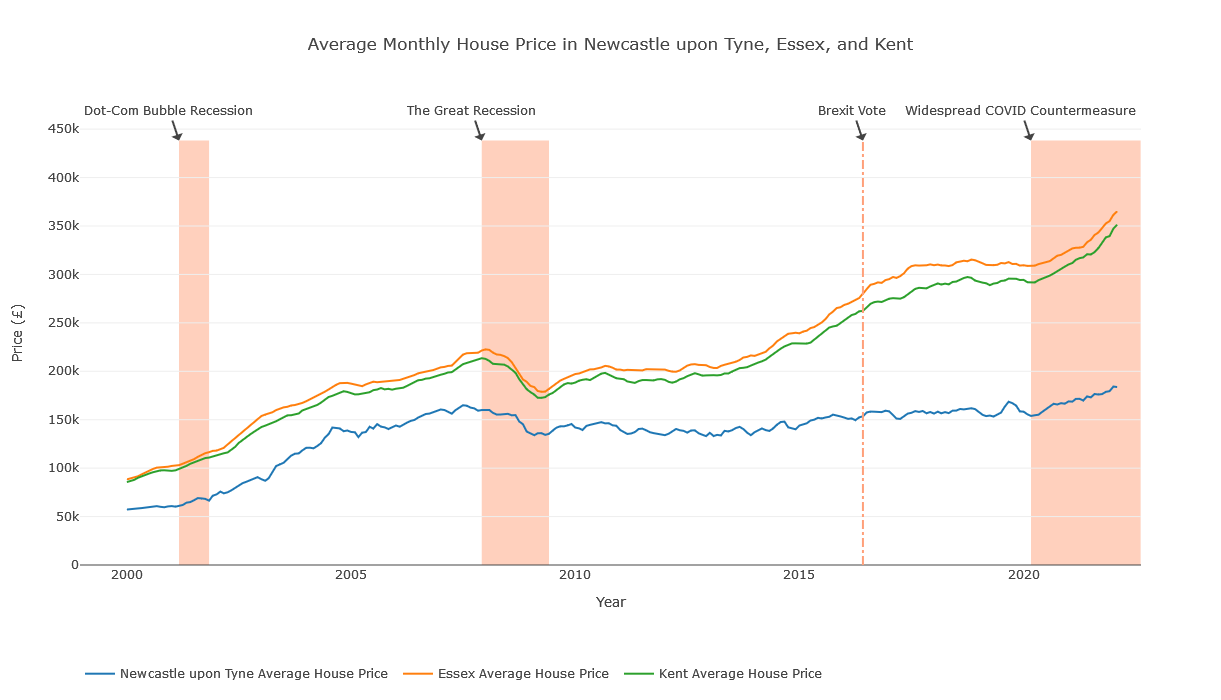

In [28]:
region_input = ['Newcastle upon Tyne','Essex','Kent']

data_reg1 = df2[df2['Region_Name'] == region_input[0]]
data_reg2 = df2[df2['Region_Name'] == region_input[1]]
data_reg3 = df2[df2['Region_Name'] == region_input[2]]

data_avg_max = max(max(data_reg1["Average_Price"]), max(data_reg2["Average_Price"]), max(data_reg3["Average_Price"]))

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_reg1["Date"], 
                         y=data_reg1["Average_Price"],
                         mode='lines',
                         name=f'{region_input[0]} Average House Price',
                    ))

fig.add_trace(go.Scatter(x=data_reg2["Date"], 
                         y=data_reg2["Average_Price"],
                         mode='lines',
                         name=f'{region_input[1]} Average House Price',
                    ))

fig.add_trace(go.Scatter(x=data_reg3["Date"], 
                         y=data_reg3["Average_Price"],
                         mode='lines',
                         name=f'{region_input[2]} Average House Price',
                    ))

fig.update_layout(
        template='gridon',
        title=f"""Average Monthly House Price in {region_input[0]}, {region_input[1]}, and {region_input[2]}""",
        xaxis_title='Year',
        yaxis_title='Price (£)',
        xaxis_showgrid=False,
        yaxis_showgrid=True,
        width=1200,
        height=700,
        legend=dict(y=-.2, orientation='h'),
        shapes=[
                dict(
                    type="rect",
                    x0="2020-03-01",
                    y0=0,
                    x1=today.strftime("%Y-%m-%d"),
                    y1=data_avg_max*1.2,
                    fillcolor="LightSalmon",
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                ),
                dict(
                    type="line",
                    x0='2016-06-01',
                    x1='2016-06-01',
                    y0=0,
                    y1=data_avg_max*1.2,
                    line=dict(
                    color="LightSalmon",
                    dash="dashdot"
                    )
                ),
                dict(
                    type="rect",
                    x0="2007-12-01",
                    y0=0,
                    x1="2009-06-01",
                    y1=data_avg_max*1.2,
                    fillcolor="LightSalmon",
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                ),
                dict(
                    type="rect",
                    x0="2001-03-01",
                    y0=0,
                    x1="2001-11-01",
                    y1=data_avg_max*1.2,
                    fillcolor="LightSalmon",
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                )
            ],
            annotations=[
                dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=data_avg_max*1.2),
                dict(text="The Great Recession", x='2007-12-01', y=data_avg_max*1.2),
                dict(text="Brexit Vote", x='2016-06-01', y=data_avg_max*1.2),
                dict(text="Widespread COVID Countermeasure", x='2020-03-01', y=data_avg_max*1.2)
            ]
        )
fig.show()

### House Price Prediction

In [37]:
essex_mean_price = data_reg2.groupby('Date')['Average_Price'].max()
essex_mean_price

Date
2000-01-01     88363.304688
2000-02-01     89385.328125
2000-03-01     90144.000000
2000-04-01     91598.343750
2000-05-01     93582.929688
                  ...      
2021-10-01    347906.531250
2021-11-01    352631.250000
2021-12-01    355050.656250
2022-01-01    361575.312500
2022-02-01    365228.812500
Name: Average_Price, Length: 266, dtype: float32

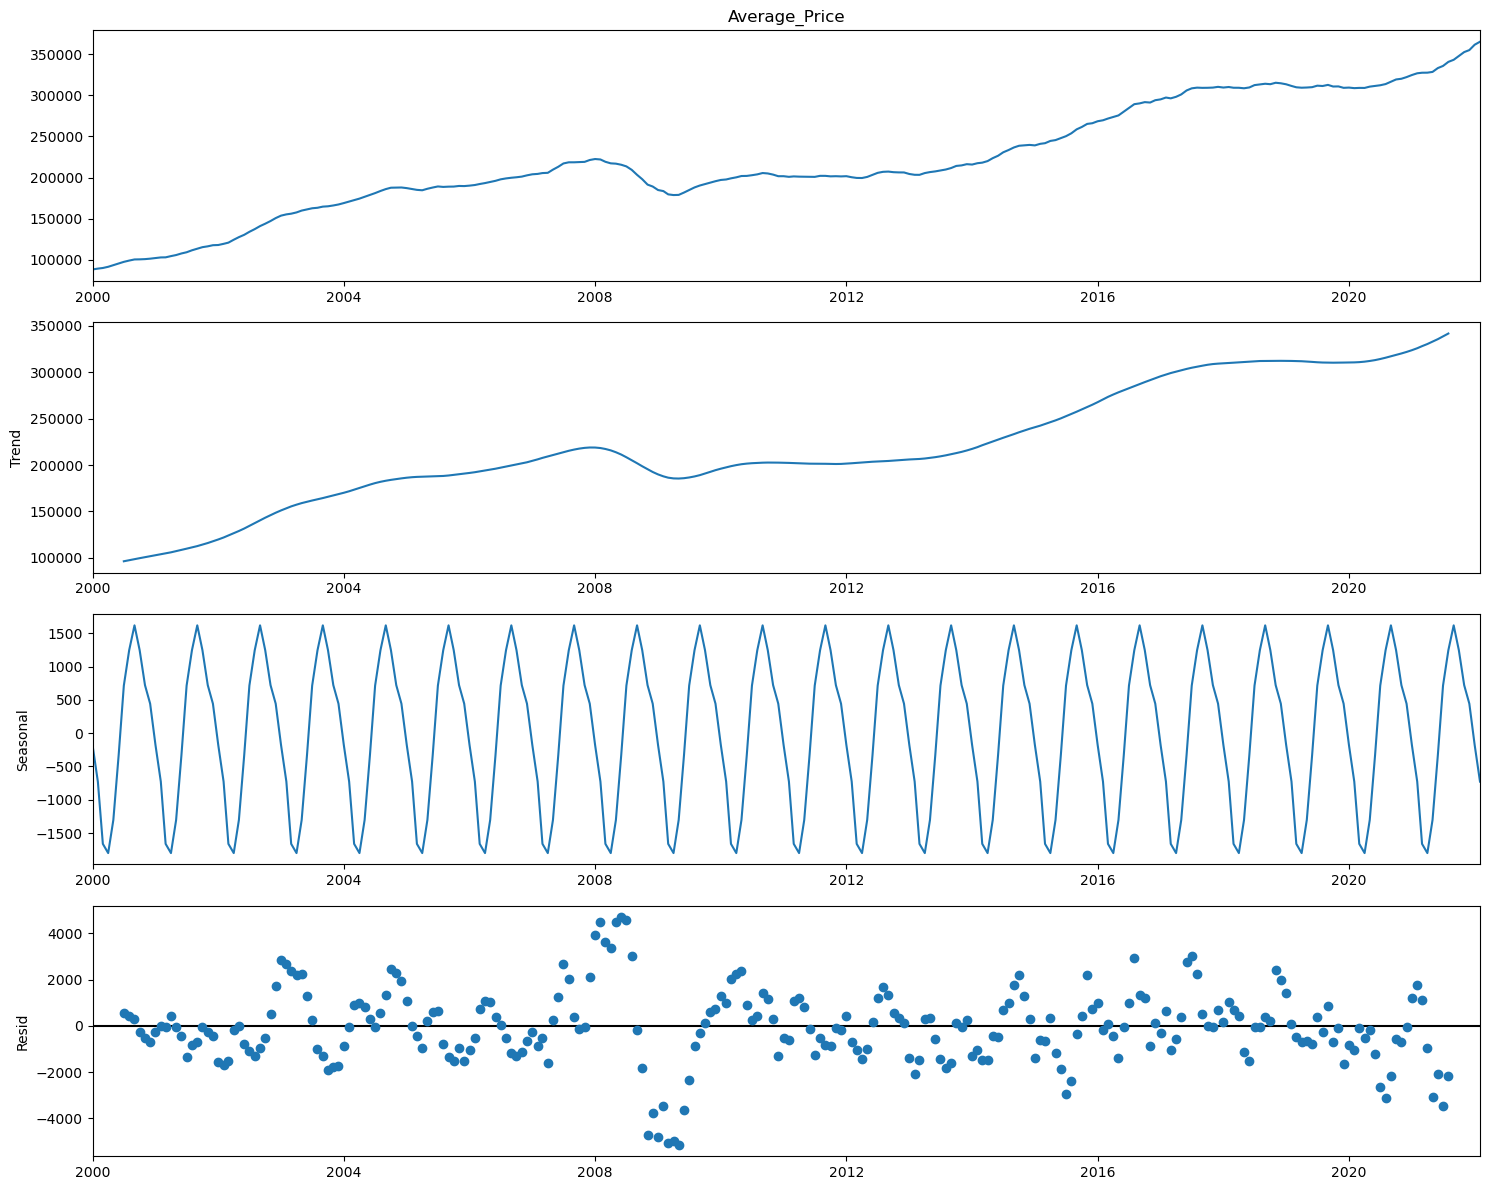

In [38]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(essex_mean_price, model='additive')
fig = decomposition.plot()
plt.show()

### Prophet

To begin the experiment, leave the data unsplitted.

In [40]:
# Prepare the data in pandas dataframe
model_df = pd.DataFrame(essex_mean_price).reset_index()
model_df = model_df.rename(columns={'Date': 'ds', 'Average_Price': 'y'})

# Initialise the model and make predictions
m = Prophet()
m.fit(model_df)

future = m.make_future_dataframe(periods=24, freq='M')

forecast = m.predict(future)

# Visualise the prediction
fig1 = m.plot(forecast)

16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1] done processing


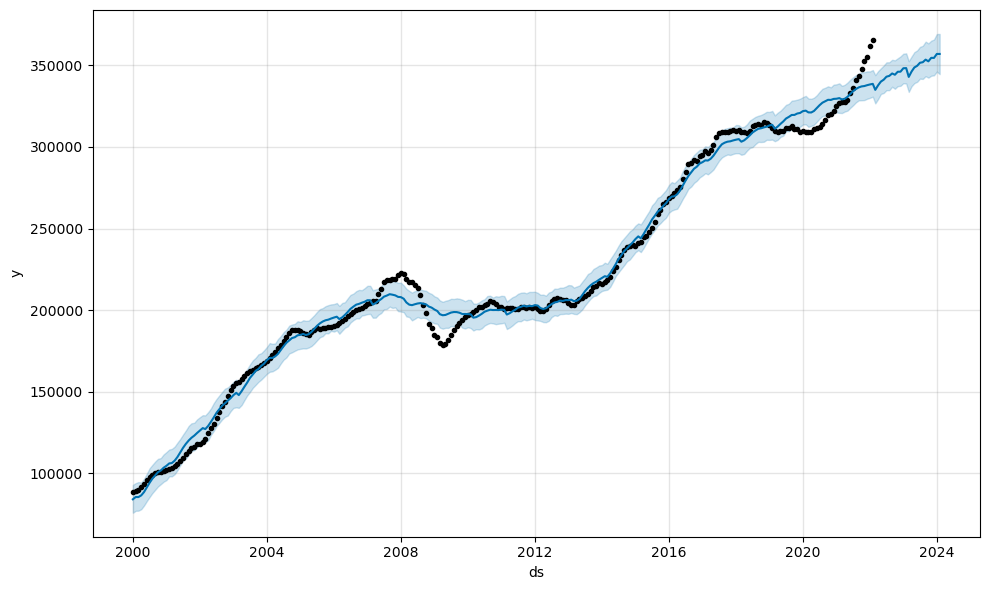

In [43]:
fig1

In [41]:
fig2 = m.plot_components(forecast)

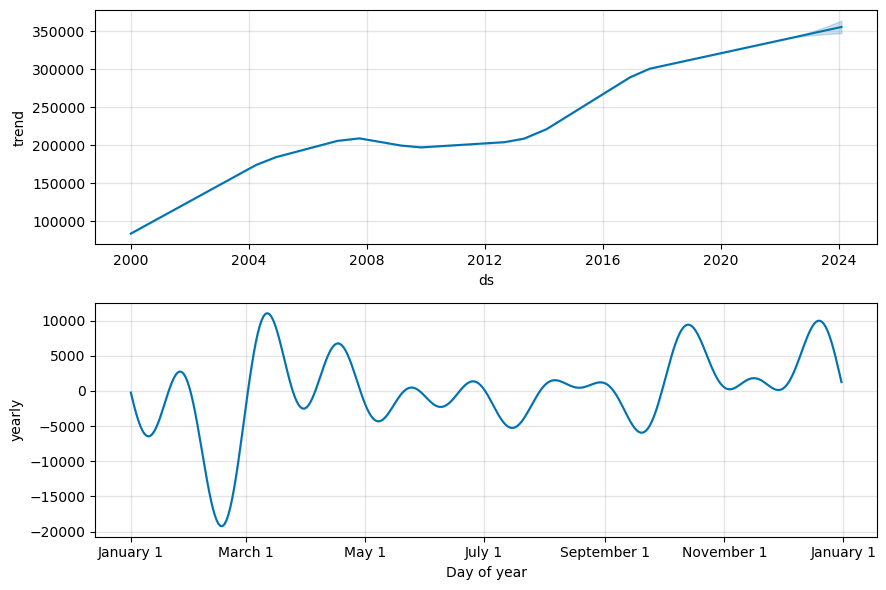

In [42]:
fig2

In [44]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,83514.681181,75910.437457,93009.122578,83514.681181,83514.681181,660.315111,660.315111,660.315111,660.315111,660.315111,660.315111,0.0,0.0,0.0,84174.996293
1,2000-02-01,85326.763459,77126.616789,94071.617793,85326.763459,85326.763459,236.243539,236.243539,236.243539,236.243539,236.243539,236.243539,0.0,0.0,0.0,85563.006998
2,2000-03-01,87021.937203,77190.558663,94697.020345,87021.937203,87021.937203,-1497.785536,-1497.785536,-1497.785536,-1497.785536,-1497.785536,-1497.785536,0.0,0.0,0.0,85524.151667
3,2000-04-01,88834.019481,78087.797404,94486.771925,88834.019481,88834.019481,-2273.625416,-2273.625416,-2273.625416,-2273.625416,-2273.625416,-2273.625416,0.0,0.0,0.0,86560.394065
4,2000-05-01,90587.647492,80274.474230,96617.928221,90587.647492,90587.647492,-2031.978057,-2031.978057,-2031.978057,-2031.978057,-2031.978057,-2031.978057,0.0,0.0,0.0,88555.669435


### Forecasting on Split Sets

Now, split data according to selected date.

Example: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet

In [53]:
data_reg1.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
101,2000-01-01,Newcastle upon Tyne,E08000021,57270.007812,-1.115234,2.443359,NaN
461,2000-02-01,Newcastle upon Tyne,E08000021,57859.632812,1.029297,5.300781,NaN
843,2000-03-01,Newcastle upon Tyne,E08000021,57952.175781,0.159912,9.398438,NaN
1234,2000-04-01,Newcastle upon Tyne,E08000021,58411.761719,0.792969,8.578125,NaN
1598,2000-05-01,Newcastle upon Tyne,E08000021,58762.707031,0.600586,7.765625,NaN


In [75]:
# newcastle_mean_price = data_reg1.groupby('Date')['Average_Price'].max()
# newcastle_mean_price

split_date = '2019-01-01'
newcastle_train = data_reg1.loc[data_reg1["Date"] <= split_date].copy()
newcastle_test = data_reg1.loc[data_reg1["Date"] > split_date].copy()

In [76]:
newcastle_train.tail()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
92181,2018-09-01,Newcastle upon Tyne,E08000021,160647.609375,-0.269043,1.667969,NaN
92630,2018-10-01,Newcastle upon Tyne,E08000021,161058.109375,0.255615,1.280273,NaN
93026,2018-11-01,Newcastle upon Tyne,E08000021,161841.156250,0.486084,3.318359,NaN
93469,2018-12-01,Newcastle upon Tyne,E08000021,160976.296875,-0.534180,1.898438,NaN
93876,2019-01-01,Newcastle upon Tyne,E08000021,158458.312500,-1.564453,1.364258,NaN


In [77]:
newcastle_test.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
94294,2019-02-01,Newcastle upon Tyne,E08000021,155034.656250,-2.160156,-2.078125,NaN
94723,2019-03-01,Newcastle upon Tyne,E08000021,153729.484375,-0.841797,-1.836914,NaN
95132,2019-04-01,Newcastle upon Tyne,E08000021,154293.328125,0.366699,-2.251953,NaN
95583,2019-05-01,Newcastle upon Tyne,E08000021,153264.671875,-0.666504,-2.269531,NaN
95982,2019-06-01,Newcastle upon Tyne,E08000021,155243.437500,1.291016,-2.585938,NaN


In [87]:
newcastle_train.tail()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
92181,2018-09-01,Newcastle upon Tyne,E08000021,160647.609375,-0.269043,1.667969,NaN
92630,2018-10-01,Newcastle upon Tyne,E08000021,161058.109375,0.255615,1.280273,NaN
93026,2018-11-01,Newcastle upon Tyne,E08000021,161841.156250,0.486084,3.318359,NaN
93469,2018-12-01,Newcastle upon Tyne,E08000021,160976.296875,-0.534180,1.898438,NaN
93876,2019-01-01,Newcastle upon Tyne,E08000021,158458.312500,-1.564453,1.364258,NaN


In [88]:
newcastle_test.head()

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
94294,2019-02-01,Newcastle upon Tyne,E08000021,155034.656250,-2.160156,-2.078125,NaN
94723,2019-03-01,Newcastle upon Tyne,E08000021,153729.484375,-0.841797,-1.836914,NaN
95132,2019-04-01,Newcastle upon Tyne,E08000021,154293.328125,0.366699,-2.251953,NaN
95583,2019-05-01,Newcastle upon Tyne,E08000021,153264.671875,-0.666504,-2.269531,NaN
95982,2019-06-01,Newcastle upon Tyne,E08000021,155243.437500,1.291016,-2.585938,NaN


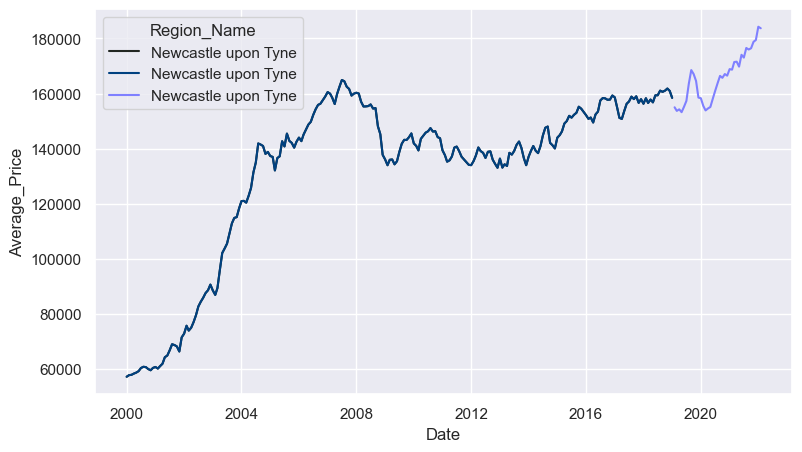

In [86]:
# Plot the responses for different events and regions
sns.set_theme()
rcParams['figure.figsize'] = 9, 5

sns.lineplot(x="Date", y="Average_Price",
             hue="Region_Name", palette="ocean",
             data=newcastle_train)
sns.lineplot(x="Date", y="Average_Price",
             hue="Region_Name", palette="cool_r",
             data=newcastle_test)
plt.show()

In [91]:
# Format data for prophet model using ds and y
newcastle_train = newcastle_train[['Date', 'Average_Price']] \
    .rename(columns={'Date':'ds',
                     'Average_Price':'y'})

newcastle_train.head()

,ds,y
101,2000-01-01,57270.007812
461,2000-02-01,57859.632812
843,2000-03-01,57952.175781
1234,2000-04-01,58411.761719
1598,2000-05-01,58762.707031


In [92]:
del m

In [93]:
model = Prophet()
model.fit(newcastle_train)

17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
newcastle_test = newcastle_test[['Date', 'Average_Price']] \
    .rename(columns={'Date':'ds',
                     'Average_Price':'y'})

newcastle_forecast = model.predict(newcastle_test)

In [95]:
newcastle_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-01,164224.895614,157756.173096,166741.266650,164224.895614,164224.895614,-1757.506165,-1757.506165,-1757.506165,-1757.506165,-1757.506165,-1757.506165,0.0,0.0,0.0,162467.389449
1,2019-03-01,164556.067454,154485.043345,163145.870952,164538.953205,164556.067454,-5699.686835,-5699.686835,-5699.686835,-5699.686835,-5699.686835,-5699.686835,0.0,0.0,0.0,158856.380619
2,2019-04-01,164922.721991,156487.721036,165625.465212,164825.469054,164962.024302,-3531.793052,-3531.793052,-3531.793052,-3531.793052,-3531.793052,-3531.793052,0.0,0.0,0.0,161390.928938
3,2019-05-01,165277.548962,159698.003793,168568.101243,165019.080275,165400.836628,-1202.181414,-1202.181414,-1202.181414,-1202.181414,-1202.181414,-1202.181414,0.0,0.0,0.0,164075.367547
4,2019-06-01,165644.203498,161969.224265,171213.830752,165203.710128,165883.440050,886.023632,886.023632,886.023632,886.023632,886.023632,886.023632,0.0,0.0,0.0,166530.227130


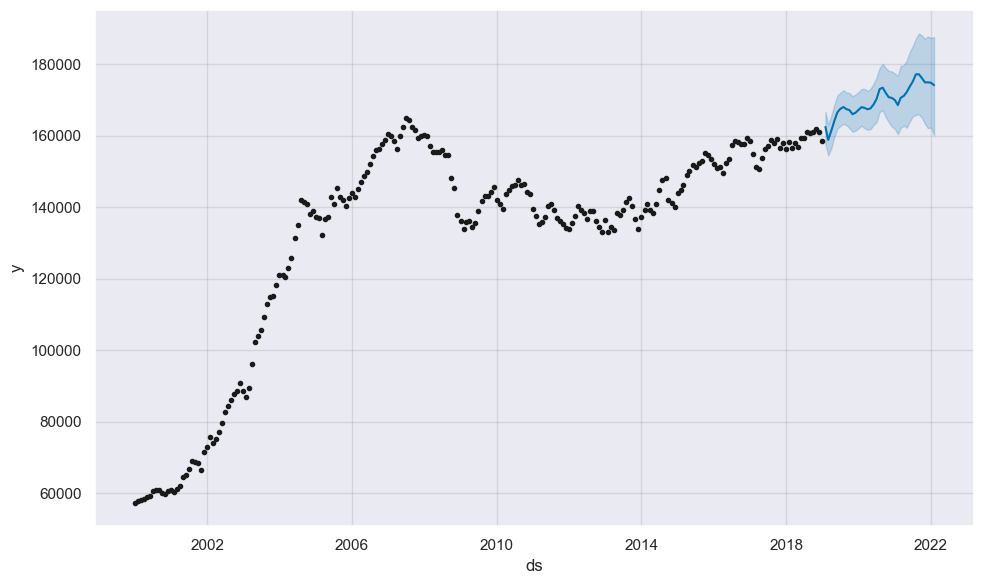

In [96]:
model.plot(newcastle_forecast)

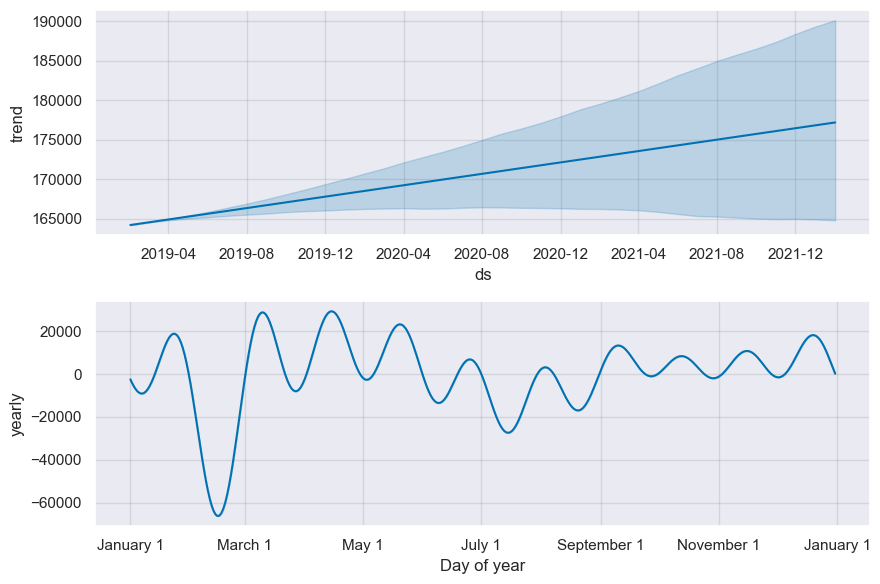

In [97]:
model.plot_components(newcastle_forecast)

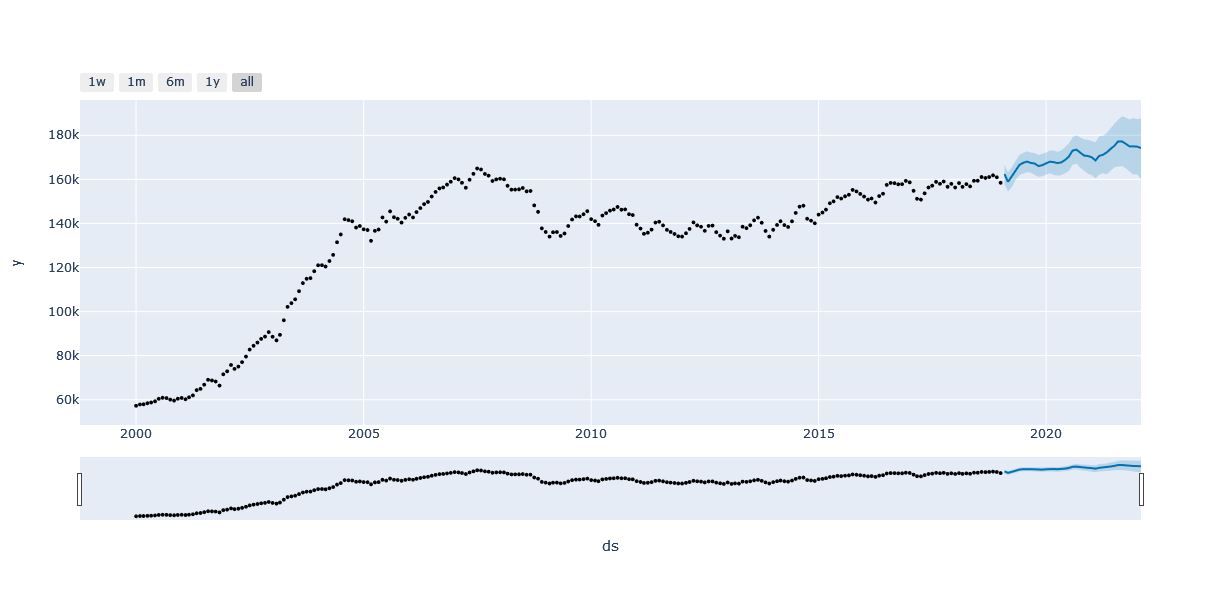

In [98]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, newcastle_forecast)

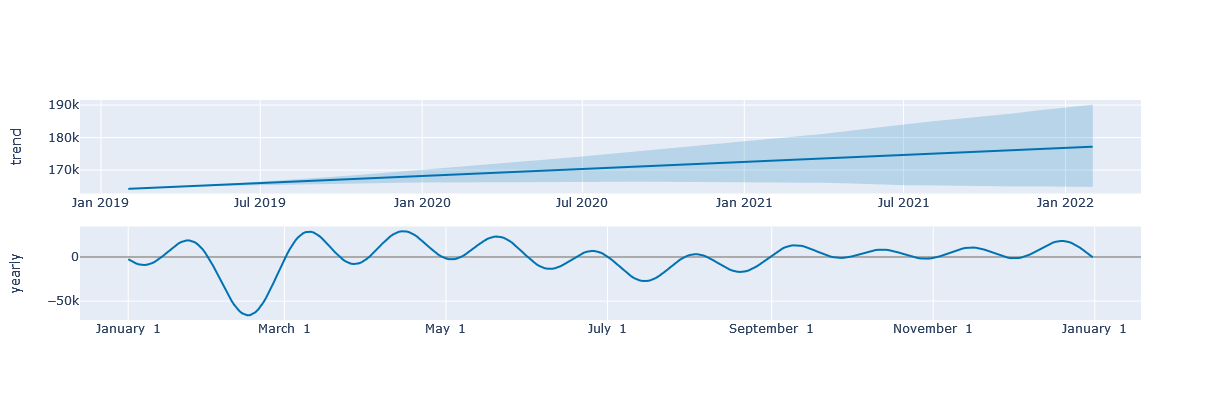

In [99]:
plot_components_plotly(model, newcastle_forecast)